In [1]:
from utils import *
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
file_paths = list(Path('./data/nyc-taxi-data').glob('*.csv'))
lazy_dfs = []

for path in file_paths:
    lf = pl.scan_csv(path)
    
    # Check if the "bad" spelling exists and fix it
    if "RateCodeID" in lf.collect_schema().names():
        lf = lf.rename({"RateCodeID": "RatecodeID"})
        
    lazy_dfs.append(lf)

# Now the schemas match perfectly
q = pl.concat(lazy_dfs)
q = q.with_columns(
    pl.col("tpep_pickup_datetime").str.to_datetime("%Y-%m-%d %H:%M:%S", strict=False),
    pl.col("tpep_dropoff_datetime").str.to_datetime("%Y-%m-%d %H:%M:%S", strict=False),
    haversine_dist(
        "pickup_latitude", "pickup_longitude", 
        "dropoff_latitude", "dropoff_longitude"
    ).alias("haversine_km"),
)
q = (q.with_columns(
    (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
    .dt.total_minutes().alias("duration_minutes")
).with_columns(
    pl.col("tpep_pickup_datetime").dt.weekday().alias("day_of_week"),
    pl.col("tpep_pickup_datetime").dt.hour().alias("hour_of_day"),
    pl.col("tpep_pickup_datetime").dt.month().alias("month_of_year"),
    pl.col("tpep_pickup_datetime").dt.year().alias("year")
).filter(
    (pl.col("duration_minutes") > 1) & 
    (pl.col("duration_minutes") < 300) & 
    (pl.col("trip_distance") > 0) &
    (pl.col("payment_type").is_in([1, 2]))
)    
.select([
        "VendorID", 
        "passenger_count", 
        "trip_distance",
        "haversine_km",
        "pickup_longitude", 
        "pickup_latitude", 
        "dropoff_longitude", 
        "dropoff_latitude",
        "RatecodeID", 
        "store_and_fwd_flag",
        "duration_minutes",
        "day_of_week", 
        "hour_of_day", 
        "month_of_year",
        "year"
    ]
))

Code above, does the following filtering:
1. Calculate the haversine distance from pickup to dropoff lat long co-ordinates
2. Removing columns we know won't be available at the time of prediction (like payment, payment type)
3. But we use columns like payment type to filter out 'bad data', i.e. payment types that are not credit card or cash, indicate unknown/ dispute/etc. which indicates potential bad data
4. Only filter duration to between 1 to 300 minutes, anything beyond that might be for NYC trip predictions 
5. Calculate some variables that we can then convert to one hot encoded later like day of week etc. 

### Most trips are between 0 to 20 minutes 

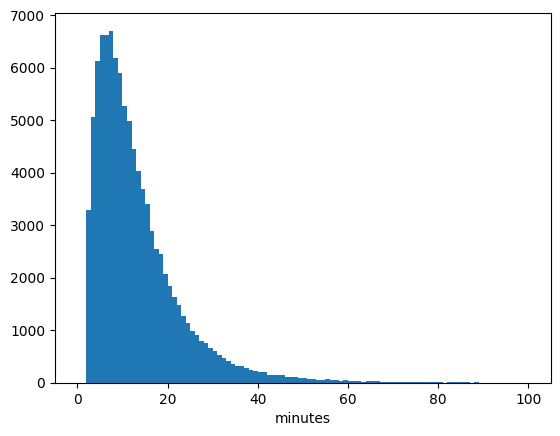

In [3]:
df = q.collect()
sample_df = df.sample(100_000)
plt.hist(sample_df["duration_minutes"], bins=100, range=(0, 100)) # Limit to 1 hour
plt.xlabel("minutes")
plt.show()

In [4]:
# q_grouped = (
#     df.lazy()
#     .agg(
#         pl.len().alias("count"),
#         pl.col("duration_minutes").mean().alias("avg_duration"),
#         pl.col("trip_distance").max().alias("longest_trip"),
#         pl.col("duration_minutes").max().alias("longest_trip_duration"),
#         pl.col("tpep_pickup_datetime").max().alias("max_date"),
#         pl.col("tpep_pickup_datetime").min().alias("min_date")
#     )
#     .sort("count", descending=True)
# )

# print(q_grouped.collect())

### continuing with the data cleaning
Data like ETA does not look like a normal bell curve so let's go ahead and use IQR to clean up some outliers

In [5]:
sl = df.lazy().select(
    pl.col("duration_minutes").quantile(0.25).alias("q1"), 
    pl.col("duration_minutes").quantile(0.75).alias("q3")
).collect()

q1_val, q3_val = sl["q1"][0], sl["q3"][0]
iqr_val = q3_val - q1_val

clean_df = df.lazy().filter(
    pl.col("duration_minutes") >= q1_val - (1.5 * iqr_val),
    pl.col("duration_minutes") <= q3_val + (1.5 * iqr_val)
)

### Some more sanity check

Distance vs duration looks like a funnel, in general growing
Lower line of this cone, is an indicator of the speed limit i.e. I can do 5 miles in 15 mins, but can't do it in 2 minutes given the speed limit / signals

As distance increases, uncertainity grows i.e. the spread of the funnel increases
Because 2 miles I can cover in more or less 10 minutes for example, but 20 miles, there's more variability, due to higher chances of red lights, congestion/ traffic, accidents

Nothing that concerns me now

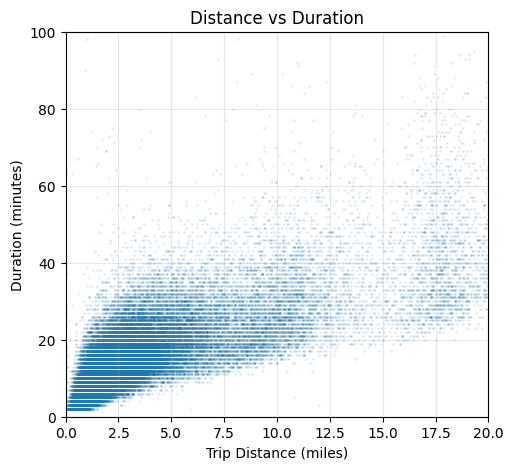

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(sample_df["trip_distance"], sample_df["duration_minutes"], alpha=0.1, s=1)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Duration (minutes)")
plt.title("Distance vs Duration")
plt.grid(True, alpha=0.3)
plt.xlim(0, 20)
plt.ylim(0, 100)

plt.show()

### Does the speed have a correlation with hour of day?
Indicator of traffic in NYC
Between 8 am and 4 pm speeds dip, i.e. work day traffic indicator

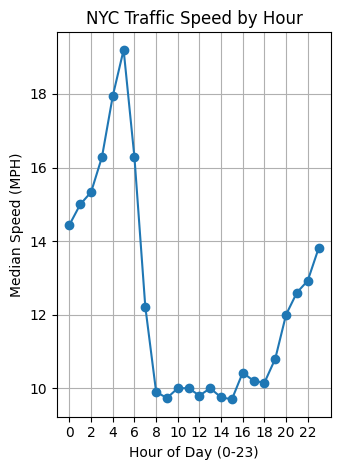

In [9]:
sample_df = sample_df.with_columns(
    (pl.col("trip_distance") / (pl.col("duration_minutes") / 60)).alias("speed_mph")
)
hourly_speed = (
    sample_df.group_by("hour_of_day")
    .agg(pl.col("speed_mph").median().alias("median_speed"))
    .sort("hour_of_day")
)

plt.subplot(1, 2, 2)
plt.plot(hourly_speed["hour_of_day"], hourly_speed["median_speed"], marker="o")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Median Speed (MPH)")
plt.title("NYC Traffic Speed by Hour")
plt.grid(True)
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

### Train test split
split 2015 as training data, and 2016 (Jan - Mar 2016 as test data) 

In [10]:
train_lf = clean_df.filter(pl.col("year") == 2015)
test_lf = clean_df.filter(pl.col("year") == 2016)

train_lf.sink_parquet("./data/train_2015.parquet")
test_lf.sink_parquet("./data/test_2016.parquet")